### Graph Creation

In [27]:
import os
import pandas as pd
import sys
sys.path.append('./brain-network-analysis/brain_analysis_tools/')
from graph_theory_indices import GraphTheoryIndices as GTI
from connectivity_graph import *
try:
    os.chdir('./brain-network-analysis')
except:
    pass

Extracting EDF parameters from C:\Users\vishw\OneDrive\Desktop\Projects\Network_Analysis_Seminar\brain-network-analysis\data\S002\S002R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF data loaded!


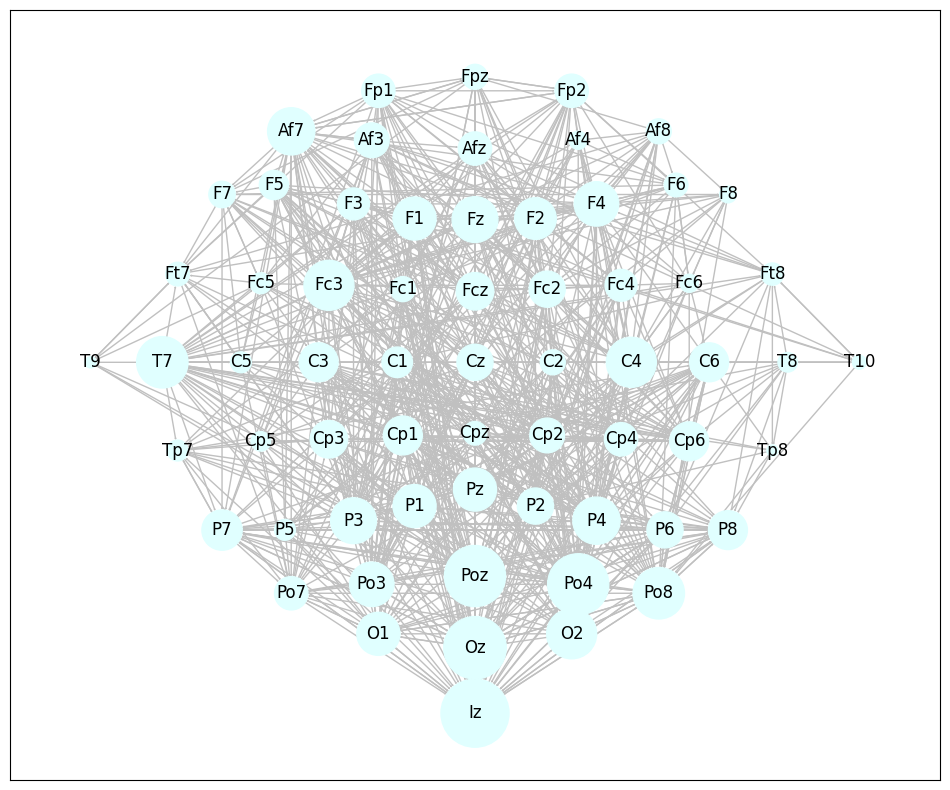

In [48]:
edf_file = "C:/Users/vishw/OneDrive/Desktop/Projects/Network_Analysis_Seminar/brain-network-analysis/data/S002/S002R02.edf"
ce_graph = GTI(edf_file)
ce_graph.compute_connectivity(freq=10, threshold=0.2,method="PCD")
ce_graph.draw_local_indices("degree")

Extracting EDF parameters from C:\Users\vishw\OneDrive\Desktop\Projects\Network_Analysis_Seminar\brain-network-analysis\data\S002\S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF data loaded!


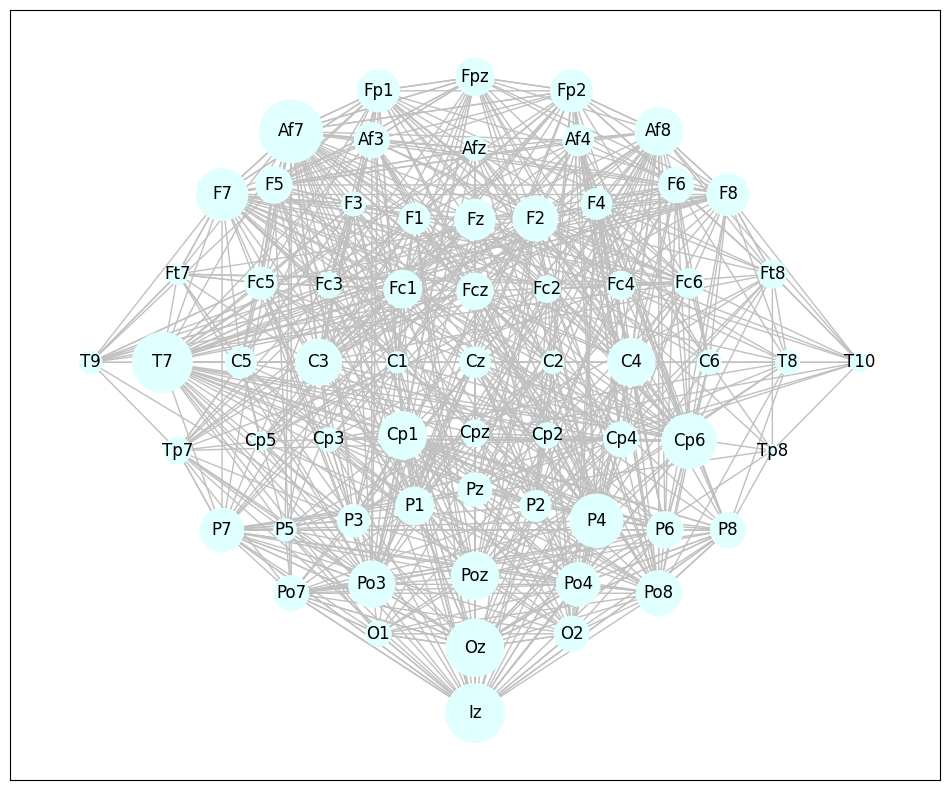

In [49]:
edf_file = "C:/Users/vishw/OneDrive/Desktop/Projects/Network_Analysis_Seminar/brain-network-analysis/data/S002/S002R01.edf"
oe_graph = GTI(edf_file)
oe_graph.compute_connectivity(freq=10, threshold=0.2,method="PCD")
oe_graph.draw_local_indices("degree")

### Saving matrix

In [36]:
edf_file = "C:/Users/vishw/OneDrive/Desktop/Projects/Network_Analysis_Seminar/brain-network-analysis/data/S002/S002R02.edf"
ce_graph = ConnectivityGraph(edf_file)
ce_graph.compute_connectivity(freq=10, threshold=0.1,method="DTF")
ce_adj_matrix = dict(ce_graph.Gw.adjacency())

adjacency = []

for i,val in ce_adj_matrix.items():
    for j,k in val.items():
        adjacency.append((i,j,k['weight']))

adjacency = pd.DataFrame(adjacency, columns=['start_node', 'end_node', 'weight'])
adjacency.to_csv("../Dataset/closed_eye_graph.csv", index=False)

Extracting EDF parameters from C:\Users\vishw\OneDrive\Desktop\Projects\Network_Analysis_Seminar\brain-network-analysis\data\S002\S002R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF data loaded!


In [37]:
edf_file = "C:/Users/vishw/OneDrive/Desktop/Projects/Network_Analysis_Seminar/brain-network-analysis/data/S002/S002R01.edf"
oe_graph = GTI(edf_file)
oe_graph.compute_connectivity(freq=10, threshold=0.1,method="DTF")
oe_adj_matrix = dict(oe_graph.Gw.adjacency())

adjacency = []

for i,val in oe_adj_matrix.items():
    for j,k in val.items():
        adjacency.append((i,j,k['weight']))

adjacency = pd.DataFrame(adjacency, columns=['start_node', 'end_node', 'weight'])
adjacency.to_csv("../Dataset/open_eye_graph.csv", index=False)

Extracting EDF parameters from C:\Users\vishw\OneDrive\Desktop\Projects\Network_Analysis_Seminar\brain-network-analysis\data\S002\S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF data loaded!


### Node Feature Extraction

In [38]:
import mne
import numpy as np
from scipy.integrate import simps
import pandas as pd

In [63]:
brain_regions = {
    'Frontal Lobe': ['Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6'],
    'Temporal Lobe': ['T7', 'T8', 'T9', 'T10', 'Ft7', 'Ft8', 'Tp7', 'Tp8'],
    'Parietal Lobe': ['P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6'],
    'Occipital Lobe': ['O1', 'Oz', 'O2', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'Iz'],
    'Central Region': ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6']
}

# Create a list of all regions
regions_list = list(brain_regions.keys())

def get_one_hot_encoded_vector(channel_name):
    # Initialize one-hot encoded vector
    one_hot_vector = np.zeros(len(regions_list))

    # Find the region for the given channel and set the corresponding index to 1
    for i, region in enumerate(regions_list):
        if channel_name in brain_regions[region]:
            one_hot_vector[i] = 1
            break
    
    return one_hot_vector

In [69]:
import mne
import numpy as np
import pandas as pd

def compute_band_energy(edf_file):
    # Load EEG data
    raw = mne.io.read_raw_edf(edf_file, preload=True)

    # Define frequency bands
    freq_bands = {'delta': (1, 4),
                  'theta': (4, 8),
                  'alpha': (8, 13),
                  'beta': (13, 30),
                  'gamma': (30, 45)}

    # Apply bandpass filters
    raw.filter(1, 45)

    # Compute PSD
    psd = raw.compute_psd(fmin=1, fmax=45)
    psds, freqs = psd.data, psd.freqs

    # Initialize DataFrame to store energy for each channel and band
    channel_band_energy = pd.DataFrame(columns=['Channel'] + list(freq_bands.keys()))

    # Iterate over channels
    for i, ch_name in enumerate(raw.ch_names):
        channel_energy = {'Channel': ch_name}
        # Iterate over frequency bands
        for band, (fmin, fmax) in freq_bands.items():
            freq_idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
            channel_energy[band] = np.sum(psds[i, freq_idx])
        channel_band_energy = channel_band_energy.append(channel_energy, ignore_index=True)

    return channel_band_energy

# Example usage:
edf_file = "C:/Users/vishw/OneDrive/Desktop/Projects/Network_Analysis_Seminar/brain-network-analysis/data/S002/S002R01.edf"
b = compute_band_energy(edf_file)
energy_df['max_energy_band'] = energy_df[['delta', 'theta', 'alpha', 'beta', 'gamma']].idxmax(axis=1)
energy_df['Channel'] = energy_df['Channel'].apply(lambda x: x.split('.')[0])
energy_df.to_csv("../Dataset/open_eyes_energy.csv", index=False)

# S002R02 energy
edf_file = "C:/Users/vishw/OneDrive/Desktop/Projects/Network_Analysis_Seminar/brain-network-analysis/data/S002/S002R02.edf"
energy_df = compute_band_energy(edf_file)
energy_df['max_energy_band'] = energy_df[['delta', 'theta', 'alpha', 'beta', 'gamma']].idxmax(axis=1)
energy_df['Channel'] = energy_df['Channel'].apply(lambda x: x.split('.')[0])
energy_df.to_csv("../Dataset/closed_eyes_energy.csv", index=False)


Extracting EDF parameters from C:\Users\vishw\OneDrive\Desktop\Projects\Network_Analysis_Seminar\brain-network-analysis\data\S002\S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 529 samples (3.306 s)

Effective window size : 12.800 (s)
Extracting EDF parameters from C:\Users\vishw\OneDrive\Desktop\Projects\Network_Analysis_Seminar\brain-network-analysis\d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
C:\Users\vishw\AppData\Local\Temp\ipykernel_89584\2130175584.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  channel_band_energy = channel_band_energy.append(channel_energy, ignore_index=True)
C:\Users\vishw\AppData\Local\Temp\ipykernel_89584\2130175584.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  channel_band_energy = channel_band_ener